# Dacon 데이터를 활용한 오디오 멀티모달 실습

**목표**  
기침소리를 듣고 코로나 바이러스 감염 여부를 판단하는 모델 구축  

**데이터**  
- input data
    - 기침소리.wav
    - 검사자에 대한 기본정보.csv : 나이, 성별, 호흡기질환여부, 발열및근육통여부
- output data: 코로나19 음성/양성 여부

**데이터세트 다운로드** : https://dacon.io/competitions/official/235910/overview/description

**개요**
- 오디오데이터 수치화
- 정형데이터와 오디오데이터 결합
- 모델을 이용하여 분류

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import joblib
import random
from tqdm import tqdm

# 오디오 데이터처리
import librosa
import librosa.display
import IPython.display as ipd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# 모델
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

## 변수설정

In [156]:
# 오디오 데이터 처리하는데 필요한 변수
sample_rate = 16000 # 사람목소리는 대부분 16000 안에 포함됨
n_mfcc = 30 # mfcc coefficient 개수

# DNN 모델에 필요한 변수
n_epochs = 100
batch_size = 128

In [167]:
device = torch.device('cpu')
# device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cpu')

## 데이터 확인 및 전처리

In [4]:
def get_meta_data(csv_path):
    df = pd.read_csv(csv_path)
    df['gender'] = np.where(df['gender']=='male', 0, 1)
    return df

In [5]:
train_df = get_meta_data('./data/covid19/train_data.csv')
test_df = get_meta_data('./data/covid19/test_data.csv')

In [6]:
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,1,0,1,0
1,2,51,0,0,0,0
2,3,22,0,0,0,0
3,4,29,1,1,0,0
4,5,23,0,0,0,0
...,...,...,...,...,...,...
3800,3801,53,0,0,0,0
3801,3802,25,0,0,0,0
3802,3803,26,1,0,0,0
3803,3804,27,1,0,0,0


In [7]:
test_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,1,1,0
1,3807,24,1,0,0
2,3808,29,0,0,0
3,3809,39,1,0,0
4,3810,34,0,0,0


In [8]:
# 오디오 확인
ipd.Audio('./data/covid19/train/00001.wav')

## 오디오 데이터 특징 추출
**mfcc(Mel-frequency cepstral coefficients)**
- 비슷한 특징을 가지는 오디오 데이터여도 녹음되는 시간, 텀, 길이 등이 동일할 수는 없다.
- 이를 해결하기 위해 mfcc를 사용하는데, 오디오데이터를 특징벡터화한다.
- 입력된 소리 전체를 대상으로 하지 않고 사람이 인지하기 좋은 mel-scale로 오디오 데이터를 모두 20~40ms 사이값으로 나누어
  이 구간에 대한 스펙트럼을 분석하고, 퓨리에 변환을 한 특징 추출방법이다.
- 사람의 음성이 20~40ms 사이에 바뀔 수 없다는 연구결과를 기반으로 정해진 값이다.
- mel_sacle을 사용한다. mel은 사람의 달팽이관을 모티브로 하여 주파수가 높고 낮음에 따라 주파수변화를 잘 감지하지 못하는 특징을 이용해 scaling하는 기법이다.

In [9]:
def get_data(data_path, df, train=True):
    ids = []
    labels = []
    ages = []
    genders = []
    respiratories = []
    fever_or_muscle = []
    mfccs = []
    
    for file in tqdm(os.listdir(data_path)):
        if 'wav' in file:
            data_id = int(file[:-4])
            ids.append(data_id)
            
            wav_path = os.path.join(data_path, file)
            data, sr = librosa.load(wav_path, sr=sample_rate)
            mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
            
            age = int(df[df.id==int(file[:-4])].age)
            ages.append(age)
            
            gen = int(df[df.id==int(file[:-4])].gender)
            genders.append(gen)
            
            resp = int(df[df.id==int(file[:-4])].respiratory_condition)
            respiratories.append(resp)
            
            pain = int(df[df.id==int(file[:-4])].fever_or_muscle_pain)
            fever_or_muscle.append(pain)

            mean_mfcc = []
            for m in mfcc:
                mean_mfcc.append(np.mean(m))
            mfccs.append(mean_mfcc)
            
            if train:
                label = int(df[df.id==int(file[:-4])].covid19)
                labels.append(label)
            # break
                
    if train:
        meta_data = {'id':ids,
                     'label':labels,
                     'age':ages,
                     'gender':genders,
                     'respiratory':respiratories,
                     'fever_or_muscle':fever_or_muscle
                    }
        df_meta = pd.DataFrame(meta_data)
        return df_meta, mfccs
    else:
        meta_data = {'id':ids,
                     'age':ages,
                     'gender':genders,
                     'respiratory':respiratories,
                     'fever_or_muscle':fever_or_muscle
                    }
        df_meta = pd.DataFrame(meta_data)
        return df_meta, mfccs

In [10]:
def make_train_mfcc_df(data_path, df):
    df_meta, mfccs = get_data(data_path, df, train=True)
    df_mfcc = pd.DataFrame(mfccs, columns=['mfcc' + str(i+1) for i in range(n_mfcc)])
    df = df_meta.join(df_mfcc)
    df.to_csv('./data/covid19/result/train_mfcc.csv', index=False)
    return df

In [11]:
def make_test_mfcc_df(data_path, df):
    df_meta, mfccs = get_data(data_path, df, train=False)
    df_mfcc = pd.DataFrame(mfccs, columns=['mfcc' + str(i+1) for i in range(n_mfcc)])
    df = df_meta.join(df_mfcc)
    df.to_csv('./data/covid19/result/test_mfcc.csv', index=False)
    return df

In [12]:
train_mfcc = make_train_mfcc_df('./data/covid19/train', train_df)
test_mfcc = make_test_mfcc_df('./data/covid19/test', test_df)

100%|██████████| 5732/5732 [18:43<00:00,  5.10it/s]


In [13]:
print(train_mfcc['label'].value_counts())
train_mfcc.head()

0    3499
1     306
Name: label, dtype: int64


,id,label,age,gender,respiratory,fever_or_muscle,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30
0,3638,0,47,1,0,0,-451.028625,51.938683,11.186030,8.042978,...,-1.384447,-1.395641,-1.477568,-0.872617,-3.008388,-1.094263,-3.208570,-1.545334,-1.466015,-0.028134
1,1853,0,28,0,0,0,-478.638153,85.071014,-25.836643,-5.198516,...,-7.806749,-1.044235,0.926861,-0.317869,-2.786085,0.153610,-4.798975,-0.970022,-5.904929,-1.728277
2,1936,0,25,0,0,0,-373.023376,35.737026,-28.746914,19.049564,...,-6.477847,-2.476339,-2.332044,-3.299588,-2.807401,-0.457428,-1.380324,1.456891,-1.078232,0.156972
3,2503,0,30,0,0,0,-394.447235,36.471512,3.533609,-5.692950,...,-6.667870,0.358603,-1.803418,0.388803,-2.935506,1.552191,-1.479025,0.247828,-2.637191,0.849459
4,1891,0,24,1,1,0,-567.596558,23.823799,-2.382252,0.528296,...,-3.264246,5.795261,0.988030,1.190986,2.038810,0.106718,-0.446323,2.174573,-1.556263,2.077411


In [14]:
test_mfcc.head()

,id,age,gender,respiratory,fever_or_muscle,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30
0,7156,39,0,0,0,-557.693054,11.824889,-7.768660,1.990406,-4.648831,...,-0.052994,-1.036629,-0.019211,0.777140,-1.178313,0.324677,-1.112595,1.258755,0.148255,0.117655
1,6346,14,0,1,0,-341.514954,40.653702,-7.158397,6.964444,-12.149445,...,-3.847776,2.538844,-5.894258,0.316437,-3.987673,-1.610037,-2.464998,-0.678776,-2.502688,-0.431717
2,8362,60,0,0,1,-364.675842,30.083925,-12.183255,-3.741531,-12.414503,...,1.570372,2.416722,-0.460442,0.018361,-0.640725,-1.157753,-1.044684,-1.025305,-0.754710,0.103205
3,6922,40,1,0,0,-443.188751,102.167419,11.805738,3.770451,-28.249481,...,-0.673473,-0.707690,1.372079,-5.728369,-1.404120,-1.230124,-5.558823,-5.810286,-1.834890,0.017993
4,8136,29,0,0,1,-430.113037,43.843662,-18.473192,1.207040,4.990799,...,-6.315275,-0.518775,-4.960499,1.218622,-3.656351,-0.170184,-3.604274,-1.299026,-5.100089,0.400216


### 오디오 특성 시각화
- harmonic(고조파): 특정한 주파수가 일정하게 유지될 때 나타나는 특성
- percussive(퍼커시브): 파형이 반복적으로 등장할 때 나타나는 특성

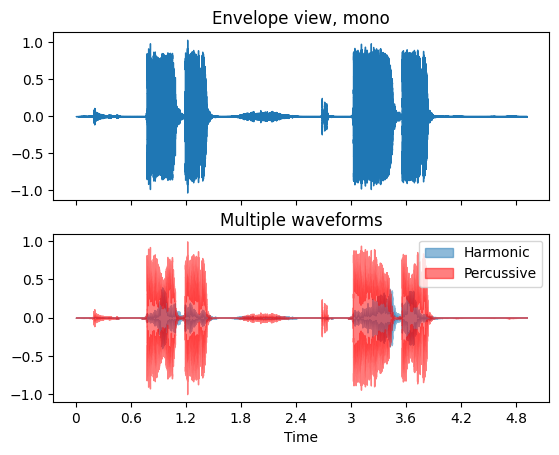

In [15]:
# 시각화 예시
y, sr = librosa.load('./data/covid19/train/00001.wav', sr=sample_rate, duration=10)
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

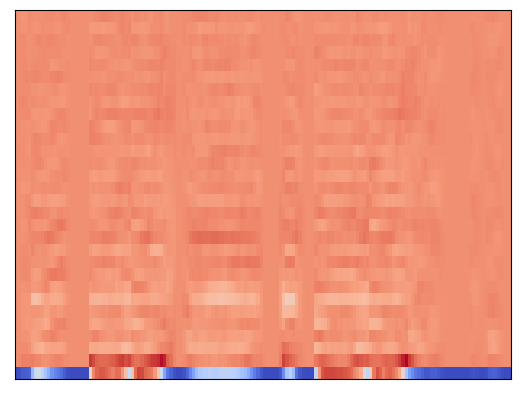

In [16]:
y_mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=n_mfcc)
librosa.display.specshow(y_mfcc, sr=sr)

## Normalizatoin

In [17]:
train_mfcc_org = pd.read_csv('./data/covid19/result/train_mfcc.csv')
test_mfcc_org = pd.read_csv('./data/covid19/result/test_mfcc.csv')

In [18]:
sc = MinMaxScaler()
train_mfcc = sc.fit_transform(train_mfcc_org)
train_mfcc = pd.DataFrame(train_mfcc, columns=train_mfcc_org.columns)

## Over sampling

In [158]:
train_mfcc = pd.read_csv('./data/covid19/result/train_mfcc.csv')
test_mfcc = pd.read_csv('./data/covid19/result/test_mfcc.csv')

In [159]:
X = train_mfcc.drop(['id', 'label'], axis=1)
y = train_mfcc['label']

sampler = SMOTE(random_state=100)
X_sample, y_sample = sampler.fit_resample(X, y)
print('-----Over Sampling-----')
print(y.value_counts())
print(y_sample.value_counts())

X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=100, stratify=y_sample)
print('-----Train Valid Split-----')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

-----Over Sampling-----
0    3499
1     306
Name: label, dtype: int64
0    3499
1    3499
Name: label, dtype: int64
-----Train Valid Split-----
(5598, 34) (5598,) (1400, 34) (1400,)


## 모델 학습 Random Forest Model

In [160]:
# random forest
model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)
joblib.dump(model, 'SMOTE_RF.pkl')

val_pred = model.predict(X_val)
rf_accuracy = accuracy_score(y_val, val_pred)
rf_accuracy

0.9507142857142857

## 모델 학습 MLP Model

In [161]:
# MLP
model = MLPClassifier(random_state=100)
model.fit(X_train, y_train)
joblib.dump(model, 'SMOTE_MLP.pkl')

val_pred = model.predict(X_val)
mlp_accuracy = accuracy_score(y_val, val_pred)
mlp_accuracy

0.8428571428571429

## 모델 학습 Deep Learning

In [162]:
X_sample

,age,gender,respiratory,fever_or_muscle,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30
0,47,1,0,0,-451.028630,51.938683,11.186030,8.042978,-2.321855,6.359078,...,-1.384447,-1.395641,-1.477568,-0.872617,-3.008388,-1.094263,-3.208570,-1.545333,-1.466015,-0.028134
1,28,0,0,0,-478.638150,85.071014,-25.836643,-5.198516,-3.667314,3.631237,...,-7.806749,-1.044235,0.926861,-0.317869,-2.786085,0.153610,-4.798974,-0.970022,-5.904929,-1.728277
2,25,0,0,0,-373.023380,35.737026,-28.746914,19.049564,-1.085256,9.464191,...,-6.477847,-2.476339,-2.332044,-3.299588,-2.807401,-0.457428,-1.380324,1.456891,-1.078232,0.156972
3,30,0,0,0,-394.447240,36.471510,3.533609,-5.692950,-0.892418,-5.889852,...,-6.667870,0.358603,-1.803418,0.388803,-2.935506,1.552191,-1.479025,0.247828,-2.637191,0.849459
4,24,1,1,0,-567.596560,23.823800,-2.382252,0.528296,-5.694057,-3.784110,...,-3.264246,5.795261,0.988030,1.190986,2.038810,0.106718,-0.446323,2.174573,-1.556263,2.077411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,13,1,1,0,-332.654964,21.189345,-14.530908,6.124225,-12.183723,6.265749,...,-3.516297,0.224561,-2.422046,1.033495,-1.891788,-0.134872,-2.228603,-0.135503,-1.704868,0.858386
6994,19,0,0,1,-974.884052,2.015970,-4.265985,-0.035699,-2.157610,0.242906,...,-0.606467,-0.075978,-0.359074,0.057381,-0.276967,0.172895,-0.395341,0.115061,-0.266991,0.226511
6995,37,1,0,0,-355.117818,49.302515,-14.676643,11.351998,-9.414952,-2.937696,...,-4.355288,0.261538,-3.818523,3.312300,-1.835416,4.532132,-2.504440,3.074116,0.131805,-1.286890
6996,26,0,0,0,-507.897373,9.192968,-7.759483,1.027634,-5.506230,2.095174,...,-0.811443,-0.428047,0.317689,0.399877,-1.350506,-0.171731,-1.761925,0.007276,-1.910400,-0.617053


In [163]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        self.X = torch.tensor(self.X.values).float()
        self.y = torch.tensor(self.y).float()
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index): # index에 해당하는 data return
        X = self.X[index]
        y = self.y[index]
        return X, y

In [164]:
dataset = CustomDataset(X_sample, y_sample)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X, y = next(iter(data_loader))
print(X.shape, y.shape)

torch.Size([128, 34]) torch.Size([128])


In [168]:
class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.input_size = input_size
        
        self.layer1 = torch.nn.Sequential(nn.Linear(self.input_size, 16),
                                          nn.LeakyReLU())
        self.layer2 = torch.nn.Sequential(nn.Linear(16, 8),
                                          nn.LeakyReLU())
        self.layer3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

In [174]:
model = MyModel(X.size(-1))
model.to(device)
model

MyModel(
  (layer1): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer2): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [175]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [188]:
losses = []
best_loss = 1
dnn_accuracy = 0.0000000001

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        y = y.unsqueeze(1)
        
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    loss = running_loss/len(data_loader)
    losses.append(loss)
    
    output = (y_pred >= 0.5).float()
    accuracy = (output == y).float().mean()
        
    if accuracy > dnn_accuracy:
        dnn_accuracy = accuracy
        best_model = deepcopy(model)
        best_loss = loss
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} \tLoss {loss:.6f} \tAccuracy {accuracy}')
        
torch.save(best_model, 'SMOTE_DNN.pth')
torch.save(best_model.state_dict(), 'SMOTE_DNN_state_dict.pth')

Epoch 0/100 	Loss 0.417694 	Accuracy 0.8720930218696594
Epoch 10/100 	Loss 0.417715 	Accuracy 0.8488371968269348
Epoch 20/100 	Loss 0.418080 	Accuracy 0.7674418687820435
Epoch 30/100 	Loss 0.418338 	Accuracy 0.7790697813034058
Epoch 40/100 	Loss 0.417913 	Accuracy 0.8139534592628479
Epoch 50/100 	Loss 0.418214 	Accuracy 0.7441860437393188
Epoch 60/100 	Loss 0.418200 	Accuracy 0.7790697813034058
Epoch 70/100 	Loss 0.417895 	Accuracy 0.8488371968269348
Epoch 80/100 	Loss 0.417479 	Accuracy 0.8255813717842102
Epoch 90/100 	Loss 0.418943 	Accuracy 0.6860465407371521


## Results

In [189]:
df_result = pd.DataFrame({'model':['Random Forest', 'MLP', 'DNN'],
                          'Over Sampling':['SMOTE', 'SMOTE', 'SMOTE'],
                          'Best Accuracy': [rf_accuracy, mlp_accuracy, dnn_accuracy.to('cpu').numpy()]
                         })
df_result

,model,Over Sampling,Best Accuracy
0,Random Forest,SMOTE,0.950714
1,MLP,SMOTE,0.842857
2,DNN,SMOTE,0.94186044


## Inference

### inference 데이터 전처리

In [179]:
test_mfcc = pd.read_csv('./data/covid19/result/test_mfcc.csv')
submission = pd.DataFrame(test_mfcc['id'], columns=['id'])
test_mfcc.head()

,id,age,gender,respiratory,fever_or_muscle,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30
0,7156,39,0,0,0,-557.69305,11.824889,-7.768660,1.990406,-4.648831,...,-0.052994,-1.036629,-0.019211,0.777140,-1.178313,0.324677,-1.112595,1.258755,0.148255,0.117655
1,6346,14,0,1,0,-341.51495,40.653700,-7.158397,6.964444,-12.149445,...,-3.847776,2.538844,-5.894258,0.316437,-3.987673,-1.610037,-2.464998,-0.678776,-2.502688,-0.431717
2,8362,60,0,0,1,-364.67584,30.083925,-12.183255,-3.741531,-12.414503,...,1.570372,2.416722,-0.460442,0.018361,-0.640725,-1.157753,-1.044684,-1.025305,-0.754710,0.103205
3,6922,40,1,0,0,-443.18875,102.167420,11.805738,3.770451,-28.249481,...,-0.673473,-0.707690,1.372078,-5.728369,-1.404120,-1.230124,-5.558823,-5.810286,-1.834890,0.017993
4,8136,29,0,0,1,-430.11304,43.843662,-18.473192,1.207040,4.990799,...,-6.315275,-0.518775,-4.960499,1.218622,-3.656351,-0.170184,-3.604274,-1.299026,-5.100089,0.400216


In [180]:
test_mfcc = test_mfcc.drop('id', 1)
test_mfcc

,age,gender,respiratory,fever_or_muscle,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30
0,39,0,0,0,-557.69305,11.824889,-7.768660,1.990406,-4.648831,-0.165457,...,-0.052994,-1.036629,-0.019211,0.777140,-1.178313,0.324677,-1.112595,1.258755,0.148255,0.117655
1,14,0,1,0,-341.51495,40.653700,-7.158397,6.964444,-12.149445,-1.414687,...,-3.847776,2.538844,-5.894258,0.316437,-3.987673,-1.610037,-2.464998,-0.678776,-2.502688,-0.431717
2,60,0,0,1,-364.67584,30.083925,-12.183255,-3.741531,-12.414503,-5.245418,...,1.570372,2.416722,-0.460442,0.018361,-0.640725,-1.157753,-1.044684,-1.025305,-0.754710,0.103205
3,40,1,0,0,-443.18875,102.167420,11.805738,3.770451,-28.249481,-9.839912,...,-0.673473,-0.707690,1.372078,-5.728369,-1.404120,-1.230124,-5.558823,-5.810286,-1.834890,0.017993
4,29,0,0,1,-430.11304,43.843662,-18.473192,1.207040,4.990799,-0.712597,...,-6.315275,-0.518775,-4.960499,1.218622,-3.656351,-0.170184,-3.604274,-1.299026,-5.100089,0.400216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,45,0,0,0,-572.17320,9.105689,-0.829174,-0.307863,-4.732477,-0.854533,...,-0.655730,-0.564211,-1.021295,-0.254094,-0.449319,0.387332,-0.846026,0.629873,-0.727784,0.926431
5728,29,0,0,0,-456.15800,48.625824,-4.441581,-1.401442,-0.920838,-7.404562,...,-4.164193,-0.232711,-4.726838,1.247001,-0.786750,-0.401054,2.850337,-0.419808,0.173352,0.477245
5729,16,0,1,1,-417.80084,50.814400,13.019898,20.448591,1.456623,12.012860,...,-8.867309,-1.315411,-6.492475,-1.043842,-7.044214,-0.287284,-5.515468,2.726674,-1.899730,0.422283
5730,59,1,1,0,-272.05610,53.310350,-9.150582,7.574405,-10.160979,-7.146455,...,0.480637,1.189911,-1.252048,-2.723344,-2.778273,5.015866,-5.545660,-2.753214,-1.967517,-1.616509


### SMOTE, RF 모델

In [181]:
model = joblib.load('./SMOTE_RF.pkl')
preds = model.predict(test_mfcc)

submission['covid19'] = preds
submission.to_csv('./data/covid19/result/smote_rf.csv', index=False)
print(submission['covid19'].value_counts())
submission.head()

0    5428
1     304
Name: covid19, dtype: int64


,id,covid19
0,7156,0
1,6346,1
2,8362,0
3,6922,0
4,8136,0


### SMOTE, MLP 모델

In [182]:
model = joblib.load('./SMOTE_MLP.pkl')
preds = model.predict(test_mfcc)

submission['covid19'] = preds
submission.to_csv('./data/covid19/result/smote_mlp.csv', index=False)
print(submission['covid19'].value_counts())
submission.head()

0    4876
1     856
Name: covid19, dtype: int64


,id,covid19
0,7156,0
1,6346,0
2,8362,0
3,6922,0
4,8136,1


### SMOTE, DNN 모델

In [190]:
model = torch.load('./SMOTE_DNN.pth')
model.load_state_dict(torch.load('./SMOTE_DNN_state_dict.pth'))
model.eval()

MyModel(
  (layer1): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer2): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [191]:
# test 데이터 tensor 변환
x = torch.tensor(test_mfcc.values).float()
x = x.to(device)

# 모델 예측
preds = model(x)
preds = preds.detach().cpu().numpy()
preds

array([[0.34095326],
       [0.8753489 ],
       [0.27951545],
       ...,
       [0.8714354 ],
       [0.13352422],
       [0.78744876]], dtype=float32)

In [192]:
# 결과 DataFrame
submission['covid19'] = preds
submission['covid19'] = np.where(submission['covid19']>0.5, 1, 0)
submission.to_csv('./data/covid19/result/smote_dnn.csv', index=False)
print(submission['covid19'].value_counts())
submission.head()

0    4053
1    1679
Name: covid19, dtype: int64


,id,covid19
0,7156,0
1,6346,1
2,8362,0
3,6922,0
4,8136,0


데이콘에 제출해본 결과 가장 좋은 점수를 받은건 smote_rf모델